> **NB:** This an implementation of the algorithm in the paper below :  

>Arief-Ang, I.B., Salim, F.D., Hamilton, M. (2018). SD-HOC: Seasonal Decomposition Algorithm for Mining Lagged Time Series. In: Boo, Y., Stirling, D., Chi, L., Liu, L., Ong, KL., Williams, G. (eds) Data Mining. AusDM 2017. Communications in Computer and Information Science, vol 845. Springer, Singapore. https://doi.org/10.1007/978-981-13-0292-3_8

## Data Lagging

To address the data lagging issue in our analysis of the relationship between CO2 and the number of occupants, we need to consider the delay between people entering or exiting the room and the resulting change in CO2 levels. This delay occurs because it takes a certain amount of time for the CO2 levels to populate the room after individuals have entered or left.

To quantify this lag, we introduce the concept of the `upper bound value (UB)`. The UB represents the maximum CO2 value that can be reached in the room and is calculated based on the room volume. By determining the UB, we can estimate the time lag needed to account for the delay between occupancy changes and CO2 level changes.

The UB is calculated as follows:

$$UB = \left|\frac{RL \times RW \times RH}{C}\right|$$

where:  
- $UB$ : Upper Bound Value
- $RL$ : Room Length 
- $RW$ : Room Width
- $RH$ : Room Height
- $C$ : Constant (100)


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
# def calculate_upper_bound(rl, rw, rh, c=100):
#     ub = abs((rl * rw * rh) / c)
#     return ub

def calculate_upper_bound(rl, rw, rh, c=100):
    # use tensorflow
    rl = tf.constant(rl, dtype=tf.float32)
    rw = tf.constant(rw, dtype=tf.float32)
    rh = tf.constant(rh, dtype=tf.float32)
    c = tf.constant(c, dtype=tf.float32)
    
    ub = tf.abs((rl * rw * rh) / c)
    return ub

To calculate a line of best fit, we need to calculate the slope value between CO2 and occupancy data.  

$$SL = \frac{\sum(O_t - \bar{O_t})(C_t - \bar{C_t})}{\sum(O_t - \bar{O_t})^2}$$

where:
- $SL$ : Slope of the linear regression line
- $O_t$ : Occupancy value
- $\bar{O_t}$ : Sample means of the known occupancy value
- $C_t$ : CO2 value
- $\bar{C_t}$ : Sample means of the known CO2 value

In [4]:
def calculate_slope(occupancy_values, co2_values):

    occupancy_values = tf.constant(occupancy_values, dtype=tf.float32)
    co2_values = tf.constant(co2_values, dtype=tf.float32)
    
    # calculate the mean of occupancy values
    occupancy_mean = tf.reduce_mean(occupancy_values)
    co2_mean = tf.reduce_mean(co2_values)
    
    # calculate the numerator
    numerator = tf.reduce_sum(
        (occupancy_values - occupancy_mean) * (co2_values - co2_mean))
    
    # calculate the denominator
    denominator = tf.reduce_sum(
        (occupancy_values - occupancy_mean) ** 2)
    
    # calculate the slope
    slope = numerator / denominator
    
    return slope

Let's now calculate the intercept value of the linear regression line.

$$IC = \bar{C_t} - SL \times \bar{O_t}$$

where:
- $IC$ : Intercept of the linear regression line
- $\bar{C_t}$ : Sample means of the known CO2 value
- $SL$ : Slope of the linear regression line
- $\bar{O_t}$ : Sample means of the known occupancy value


In [5]:
def calculate_intecept_value(occupancy_values, co2_values, slope):
    
    occupancy_values = tf.constant(occupancy_values, dtype=tf.float32)
    co2_values = tf.constant(co2_values, dtype=tf.float32)
    
    # calculate the mean of occupancy values
    occupancy_mean = tf.reduce_mean(occupancy_values)
    co2_mean = tf.reduce_mean(co2_values)
    
    # calculate the intercept
    intercept = co2_mean - (slope * occupancy_mean)
    
    return intercept

Finally, the formula for the line of best fit is:

$$LBF = (O_t - (SL \times C_t + IC))^2$$

where:
- $LBF$ : Line of best fit
- $O_t$ : Occupancy value
- $SL$ : Slope of the linear regression line
- $C_t$ : CO2 value
- $IC$ : Intercept of the linear regression line


In [6]:
def calculate_line_of_best_fit(occupancy_value, co2_value, slope, intercept):
    
    occupancy_value = tf.constant(occupancy_value, dtype=tf.float32)
    co2_value = tf.constant(co2_value, dtype=tf.float32)
    
    # calculate the line of best fit
    line_of_best_fit = (occupancy_value - (slope * co2_value + intercept)) ** 2
    
    return line_of_best_fit

We then combine the line of best fit with the UB to calculate the time lag.  
  
Here is the implementation below:

In [7]:
import numpy as np

def preprocess_data(co2_values, occupancy_values, room_length, room_width, room_height, constant_value=100):
    # Convert input data to NumPy arrays
    co2_values = np.array(co2_values)
    occupancy_values = np.array(occupancy_values)

    # Step 1: Calculate the upper bound value (UB) and find the optimal time lag
    UB = abs((room_length * room_width * room_height) / constant_value)
    correlations = []
    for time_lag in range(int(UB) + 1):
        co2_lagged = co2_values[time_lag:]
        occupancy_lagged = occupancy_values[:len(occupancy_values) - time_lag]
        correlation = np.corrcoef(co2_lagged, occupancy_lagged)[0, 1]
        correlations.append(correlation)
    optimal_time_lag = np.argmax(correlations)
    
    # Step 2: Calculate the line of best fit (LBF)
    co2_lagged = co2_values[optimal_time_lag:]
    occupancy_lagged = occupancy_values[:len(occupancy_values) - optimal_time_lag]
    SL = np.sum((occupancy_lagged - np.mean(occupancy_lagged)) * (co2_lagged - np.mean(co2_lagged))) / np.sum((occupancy_lagged - np.mean(occupancy_lagged))**2)
    IC = np.mean(co2_lagged) - SL * np.mean(occupancy_lagged)
    
    # Step 3: Calculate the main formula for the line of best fit (LBF)
    preprocessed_co2_values = co2_values

    # Step 4: Calculate the metrics - Mean Squared Error (MSE), Root-Mean-Square Deviation (RMSD), and Normalized Root Mean Square Error (NRMSE)
    MSE = np.mean((occupancy_values - preprocessed_co2_values)**2)
    RMSD = np.sqrt(MSE)
    NRMSE = RMSD / (max(occupancy_values) - min(occupancy_values))
    
    # Step 5: Return preprocessed data and metrics
    preprocessed_occupancy_values = occupancy_values[optimal_time_lag:]
    
    return {
        "optimal_time_lag": optimal_time_lag,
        "slope": SL,
        "intercept": IC,
        "MSE": MSE,
        "RMSD": RMSD,
        "NRMSE": NRMSE,
        "preprocessed_co2_values": preprocessed_co2_values,
        "preprocessed_occupancy_values": preprocessed_occupancy_values
    }




## Seasonal-Trend Decomposition

STD is a method to decompose a time series into three components: trend, seasonal, and residual.  
`The trend component` $\textcolor{orange}{(T_t)}$ is the long-term progression of the series.  
`The seasonal component` $\textcolor{orange}{(S_t)}$ is the repeating short-term cycle in the series.  
`The cyclical component` $\textcolor{orange}{(C_t)}$ is the repeating up and down movements in the series that are not of a fixed period.  
`The residual component` $\textcolor{orange}{(e_t)}$ is the random variation in the series, and is calculated as the difference between the original series and the sum of the trend, seasonal, and cyclical components.

In the paper we're implementing, the cyclical component is combined with the trend component to make a simpler model.

The formula for the STD is:

In [4]:
def decompose_time_series(df):
    # Step 1: Calculate 2 × 12 moving average in the raw data
    trend_co2 = df['co2'].rolling(window=12, center=True).mean()
    trend_occupancy = df['peoplecount_rgb'].rolling(window=12, center=True).mean()

    # Step 2: Calculate centred ratios
    centred_ratios_co2 = df['co2'] / trend_co2
    centred_ratios_occupancy = df['peoplecount_rgb'] / trend_occupancy

    for _ in range(2):
        # Step 3: Calculate rough seasonal feature
        seasonal_co2 = centred_ratios_co2.rolling(window=2).mean().rolling(window=2).mean()
        seasonal_occupancy = centred_ratios_occupancy.rolling(window=2).mean().rolling(window=2).mean()

        # Step 4: Calculate irregular feature
        et_co2 = centred_ratios_co2 / seasonal_co2
        et_occupancy = centred_ratios_occupancy / seasonal_occupancy

        # Step 5: Modify irregular feature by multiplying with seasonal feature
        modified_et_co2 = et_co2 * seasonal_co2
        modified_et_occupancy = et_occupancy * seasonal_occupancy

        # Step 6: Update seasonal feature
        seasonal_co2 = modified_et_co2.rolling(window=2).mean().rolling(window=2).mean()
        seasonal_occupancy = modified_et_occupancy.rolling(window=2).mean().rolling(window=2).mean()

        # Step 7: Calculate preliminary seasonal adjusted series
        preliminary_seasonal_adjusted_co2 = df['co2'] / seasonal_co2
        preliminary_seasonal_adjusted_occupancy = df['peoplecount_rgb'] / seasonal_occupancy

        # Step 8: Estimate trend feature using weighted Henderson moving average
        trend_co2 = preliminary_seasonal_adjusted_co2.rolling(window=12, center=True).mean()
        trend_occupancy = preliminary_seasonal_adjusted_occupancy.rolling(window=12, center=True).mean()

        # Step 9: Calculate new centred ratios
        centred_ratios_co2 = df['co2'] / trend_co2
        centred_ratios_occupancy = df['peoplecount_rgb'] / trend_occupancy

        for _ in range(2):
            # Step 10: Calculate rough seasonal feature using 3 × 5 moving average
            seasonal_co2 = centred_ratios_co2.rolling(window=3, center=True).mean().rolling(window=5, center=True).mean()
            seasonal_occupancy = centred_ratios_occupancy.rolling(window=3, center=True).mean().rolling(window=5, center=True).mean()

            # Step 11: Update irregular feature using modified centred ratios and 3 × 5 moving average
            et_co2 = centred_ratios_co2 / seasonal_co2
            et_occupancy = centred_ratios_occupancy / seasonal_occupancy

            modified_et_co2 = et_co2 * seasonal_co2
            modified_et_occupancy = et_occupancy * seasonal_occupancy

            # Step 12: Update seasonal feature using 3 × 5 moving average
            seasonal_co2 = modified_et_co2.rolling(window=3, center=True).mean().rolling(window=5, center=True).mean()
            seasonal_occupancy = modified_et_occupancy.rolling(window=3, center=True).mean().rolling(window=5, center=True).mean()

            # Step 13: Calculate reminder feature
            reminder_feature_co2 = preliminary_seasonal_adjusted_co2 / trend_co2
            reminder_feature_occupancy = preliminary_seasonal_adjusted_occupancy / trend_occupancy

    return trend_co2, trend_occupancy, seasonal_co2, seasonal_occupancy, reminder_feature_co2, reminder_feature_occupancy 

Finally, the formula for the seasonal-trend decomposition is:

$$STD_t = T_t + S_t + e_t$$

We used what we call *additive model*, which means that the components are added together.

For CO2 :  
$$C_t = T_t^C + S_t^C + e_t^C$$  
For People Count :  
$$O_t = T_t^O + S_t^O + e_t^O$$

To predict the people count at time $t+1$ up to $t+n$, we need to predict the trend, seasonal and residual components at time $t+1$ up to $t+n$ first, then add them together to reconstruct the original time series.




### Testing the STD

Let's test the STD on the data we have.  
 
First, we start by calculating the upper bound value (UB) for the room, then we calculate the slope and intercept values for the line of best fit.

In [1]:
# test the functions
import pandas as pd

# read the data
df = pd.read_csv('../data/final_df.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6573 entries, 0 to 6572
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             6573 non-null   object 
 1   peoplecount_rgb  6573 non-null   int64  
 2   co2              6573 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 154.2+ KB


Optimal Time Lag: 0
Slope (SL): 16.150494173192776
Intercept (IC): 443.61987671585496
Mean Squared Error (MSE): 203106.77377148942
Root-Mean-Square Deviation (RMSD): 450.67368879433093
Normalized Root Mean Square Error (NRMSE): 112.66842219858273
Preprocessed CO2 Values: [438. 434. 454. ... 419. 422. 422.]
Preprocessed Occupancy Values: [0 0 0 ... 0 0 0]


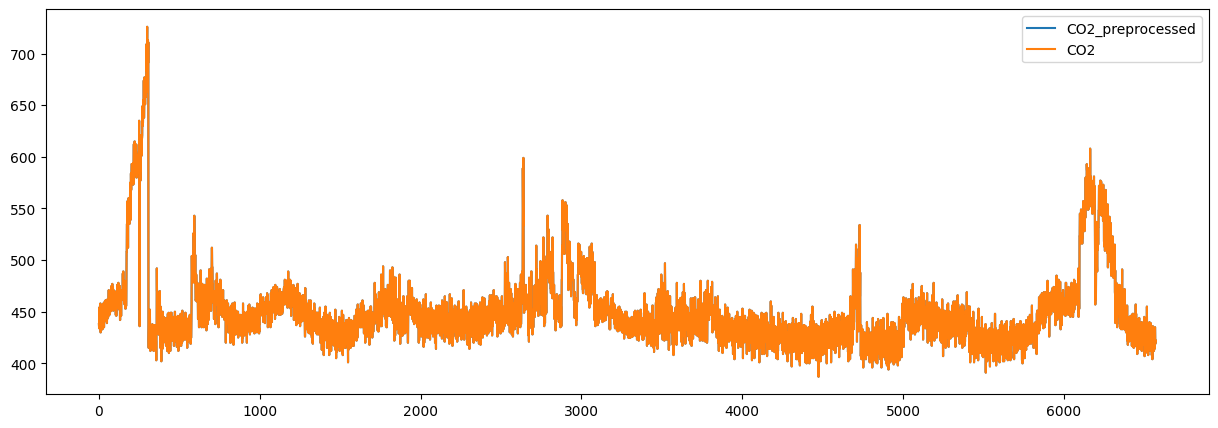

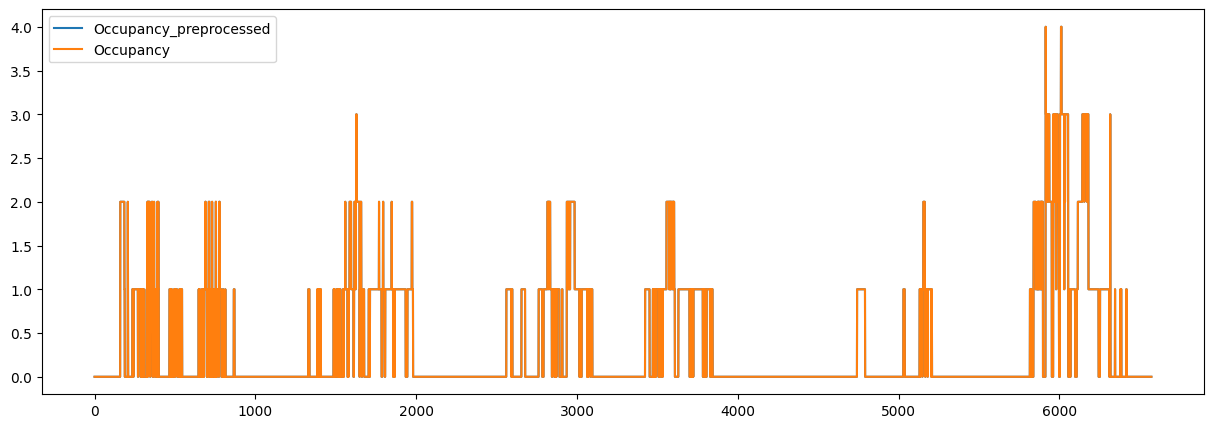

In [10]:
preprocessed_df = preprocess_data(df['co2'], df['peoplecount_rgb'], 3.5, 2.5, 2.5)
print("Optimal Time Lag:", preprocessed_df["optimal_time_lag"])
print("Slope (SL):", preprocessed_df["slope"])
print("Intercept (IC):", preprocessed_df["intercept"])
print("Mean Squared Error (MSE):", preprocessed_df["MSE"])
print("Root-Mean-Square Deviation (RMSD):", preprocessed_df["RMSD"])
print("Normalized Root Mean Square Error (NRMSE):", preprocessed_df["NRMSE"])
print("Preprocessed CO2 Values:", preprocessed_df["preprocessed_co2_values"])
print("Preprocessed Occupancy Values:", preprocessed_df["preprocessed_occupancy_values"])

# Access the preprocessed CO2 and occupancy values
# plot the preprocessed data 
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(preprocessed_df["preprocessed_co2_values"], label='CO2_preprocessed')
plt.plot(df['co2'], label='CO2')
plt.legend()
plt.show()

# use new figure to plot the occupancy
plt.figure(figsize=(15, 5))
plt.plot(preprocessed_df["preprocessed_occupancy_values"], label='Occupancy_preprocessed')
plt.plot(df['peoplecount_rgb'], label='Occupancy')
plt.legend()
plt.show()


We then proceed to calculate the trend, seasonal, and residual components for the CO2 and people count data.

Finally, we reconstruct the original time series by adding the trend, seasonal, and residual components together.

In [5]:
# decompose time series
trend_co2, trend_occupancy, seasonal_co2, seasonal_occupancy, reminder_feature_co2, reminder_feature_occupancy = decompose_time_series(df)

We can check the components by plotting them.

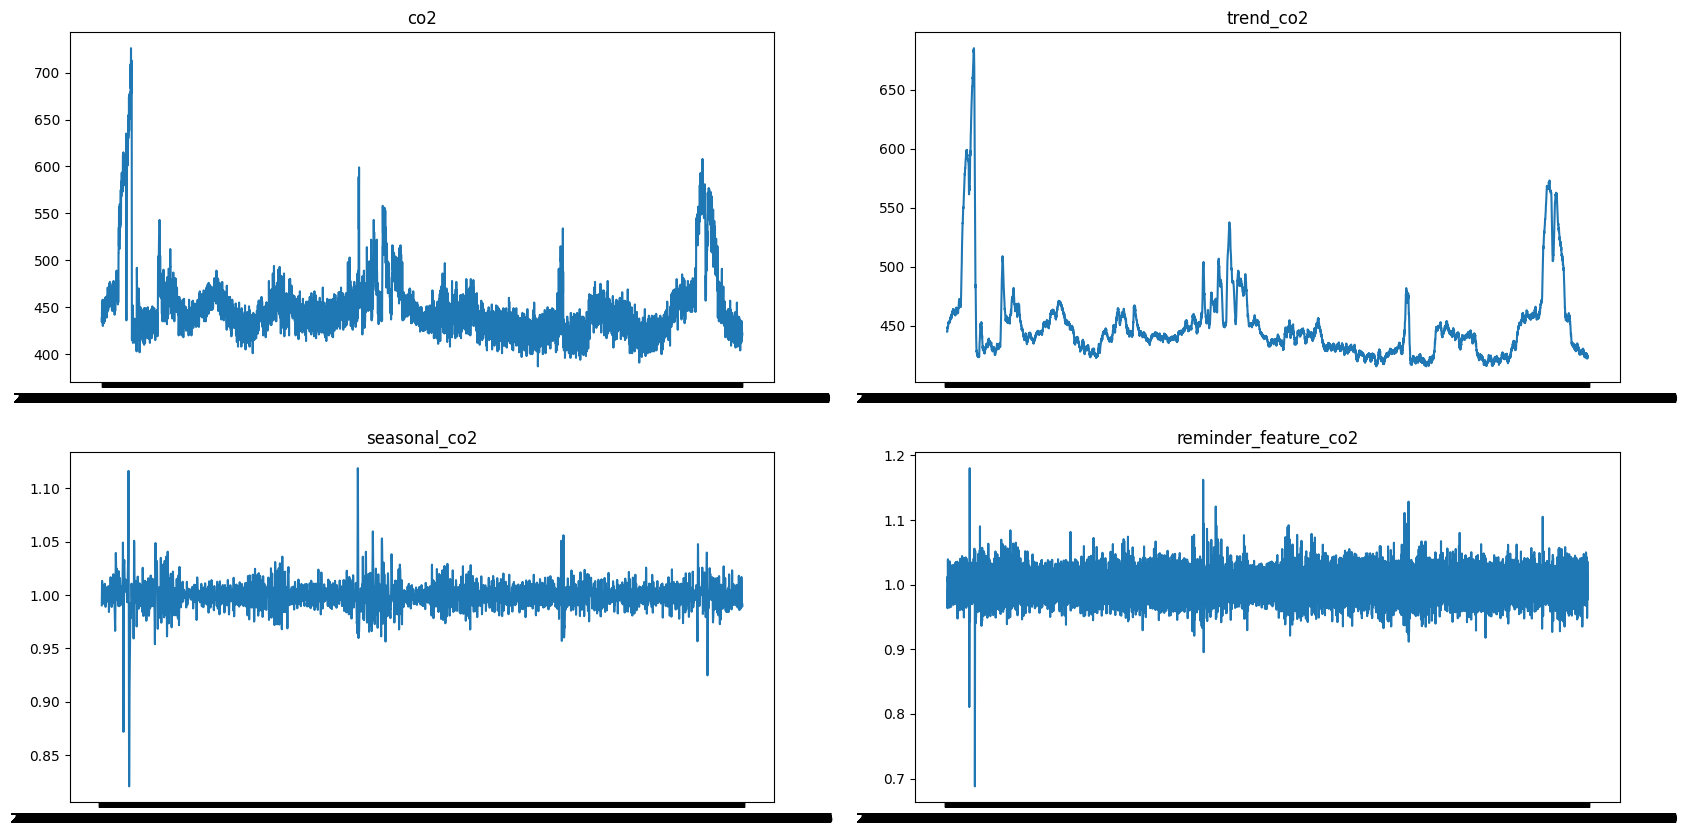

In [12]:
x = df['time']

import matplotlib.pyplot as plt
figure, axes = plt.subplots(2, 2, figsize=(20, 10))

axes[0, 0].plot(x, df['co2'], label='co2')
axes[0, 0].set_title('co2')

axes[0, 1].plot(x, trend_co2, label='trend_co2')
axes[0, 1].set_title('trend_co2')

axes[1, 0].plot(x, seasonal_co2, label='seasonal_co2')
axes[1, 0].set_title('seasonal_co2')

axes[1, 1].plot(x, reminder_feature_co2, label='reminder_feature_co2')
axes[1, 1].set_title('reminder_feature_co2')

plt.show()

We can do the same for the people count data. but in this case we first need to replace the NaN values with 0.

In [6]:
# replace all the nan values with 0
trend_occupancy = trend_occupancy.fillna(0)
seasonal_occupancy = seasonal_occupancy.fillna(0) 
reminder_feature_occupancy = reminder_feature_occupancy.fillna(0)

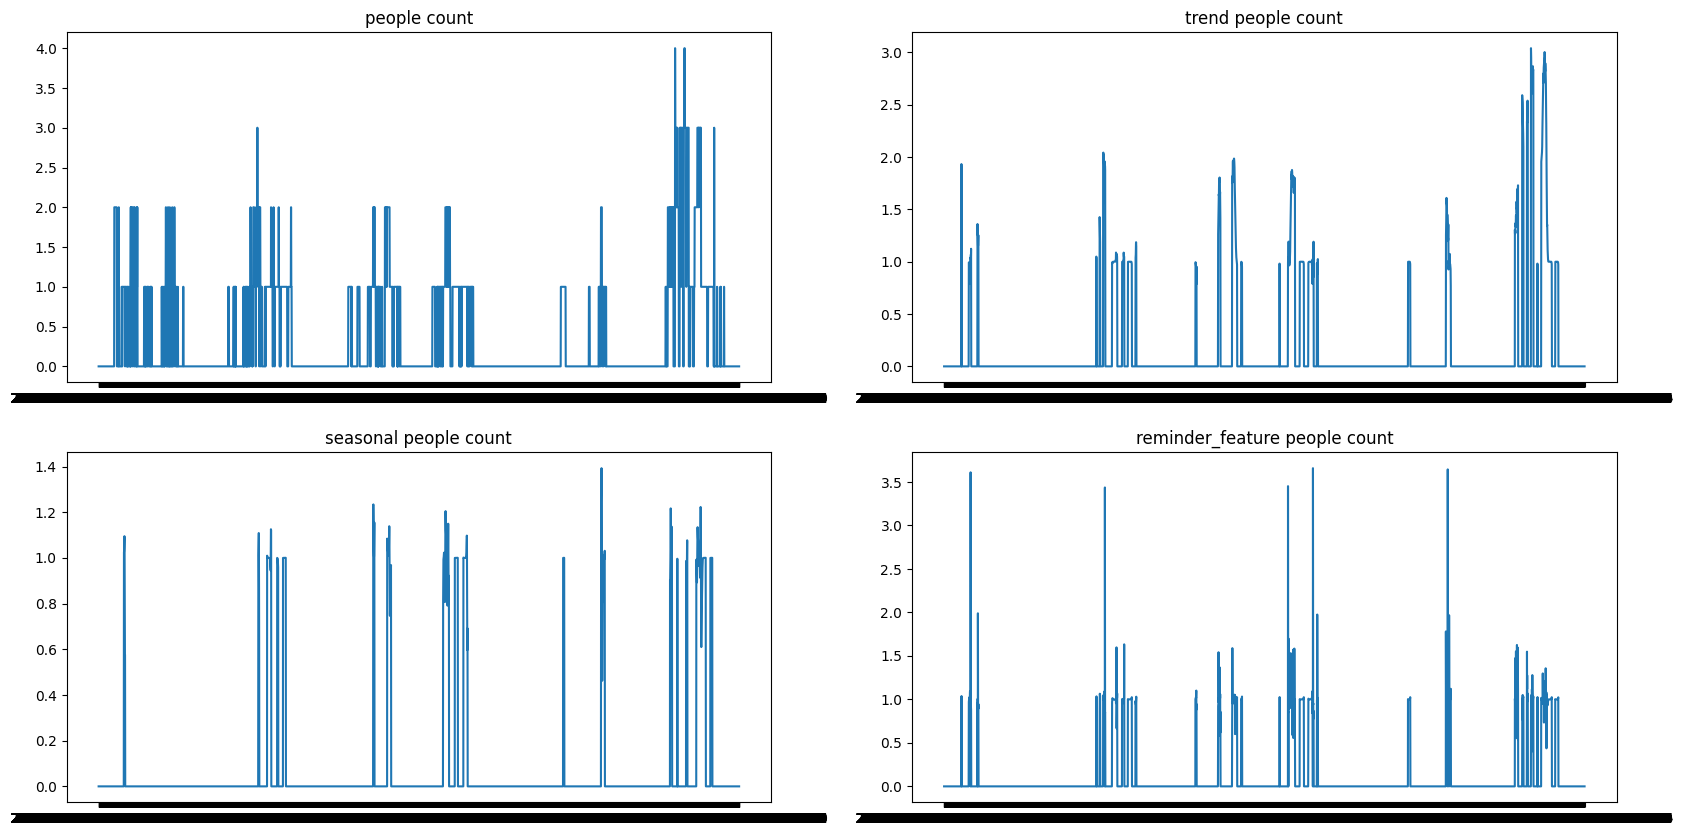

In [14]:
figure, axes = plt.subplots(2, 2, figsize=(20, 10))

axes[0, 0].plot(x, df['peoplecount_rgb'], label='people count')
axes[0, 0].set_title('people count')

axes[0, 1].plot(x, trend_occupancy, label='trend people count')
axes[0, 1].set_title('trend people count')

axes[1, 0].plot(x, seasonal_occupancy, label='seasonal people count')
axes[1, 0].set_title('seasonal people count')

axes[1, 1].plot(x, reminder_feature_occupancy, label='reminder_feature people count')
axes[1, 1].set_title('reminder_feature people count')

plt.show()

### Conclusion 

We can see that the STD works well for the CO2 data, but not for the people count data.That is mainly because the people count data is not continuous, and the STD works best for continuous data.

## Correlation Models

### Correlation Model for the Trend Component

Here we will need to check the correlation between the trend component of the CO2 data and the trend component of the people count data.  

For this we will use the `Pearson correlation coefficient`. It is defined as below:  

$$r = \frac{n(\sum xy) - (\sum x)(\sum y)}{\sqrt{(n\sum x^2 - (\sum x)^2)(n\sum y^2 - (\sum y)^2)}}$$

where:  
- $r$ : Pearson correlation coefficient
- $n$ : Number of data points
- $x$ : Trend component of the CO2 data
- $y$ : Trend component of the people count data

In [15]:
def pearson_product_moment_correlation_coefficient(occupancy_values, co2_values, n):
    # numerator
    numerator = n * tf.reduce_sum(
        occupancy_values * co2_values) - tf.reduce_sum(
            occupancy_values) * tf.reduce_sum(co2_values)
        
    # denominator
    denominator = tf.sqrt(
        tf.abs((n * tf.reduce_sum(occupancy_values ** 2) - tf.reduce_sum(occupancy_values) ** 2)) * 
        tf.abs((n * tf.reduce_sum(co2_values ** 2) - tf.reduce_sum(co2_values) ** 2)))
    
    return numerator / denominator

In [16]:
# test the function
import numpy as np

# test on the actual data
occupancy_values = tf.constant(df['co2'], dtype=tf.float32)
co2_values = tf.constant(df['peoplecount_rgb'], dtype=tf.float32)
n = tf.constant(len(df['peoplecount_rgb']), dtype=tf.float32)

co2_values_1 = tf.constant(trend_co2, dtype=tf.float32)
occupancy_values_1 = tf.constant(trend_occupancy, dtype=tf.float32)
n_1 = tf.constant(len(trend_occupancy), dtype=tf.float32)

# calculate the pearson product moment correlation coefficient
print('Correlation coefficient Pearson`s r value is ',pearson_product_moment_correlation_coefficient(occupancy_values, co2_values, n).numpy())

print('Correlation coefficient Pearson`s r value for trend components is ',pearson_product_moment_correlation_coefficient(occupancy_values_1, co2_values_1, n_1).numpy())

Correlation coefficient Pearson`s r value is  0.29420567
Correlation coefficient Pearson`s r value for trend components is  nan


We can see that the Pearson correlation coefficient is a measure of the linear correlation between two variables X and Y.  

When we run the Pearson correlation coefficient on data we didn't apply the STD on, we get a value of 0.29 which is not very high.  

When we run the Pearson correlation coefficient on data we applied the STD on, we get a nan value, which is weird and is probably due to the fact that the data is not continuous, or an error of my implementation.  

This should be investigated further.

### Machine learning algorithms

After deceiviing results from the correlation model, we decided to try machine learning algorithms to see if we can get better results. The correlation model can be solved later.

We will first try a model that I think is the most suitable for our problem, which is the `K-Nearest Neighbors` model.

As input, we will use the trend component of the CO2 data, and as output, we will use the normal people count data.

In [8]:
# try knn algorithm
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

trend_co2.fillna(0, inplace=True)

# split the data into train and test df['co2'], df['peoplecount_rgb']
X_train, X_test, y_train, y_test = train_test_split(trend_co2, df['peoplecount_rgb'], test_size=0.2, random_state=42)

# reshape the data
X_train = np.array(X_train).reshape(-1, 1)
X_test = np.array(X_test).reshape(-1, 1)

# create the model
model_1 = KNeighborsClassifier(n_neighbors=3)

# fit the model
model_1.fit(X_train, y_train)

# make predictions
y_pred = model_1.predict(X_test)

# calculate the accuracy
print('The accuracy of the model is: ', accuracy_score(y_test, y_pred))





The accuracy of the model is:  0.6889733840304183


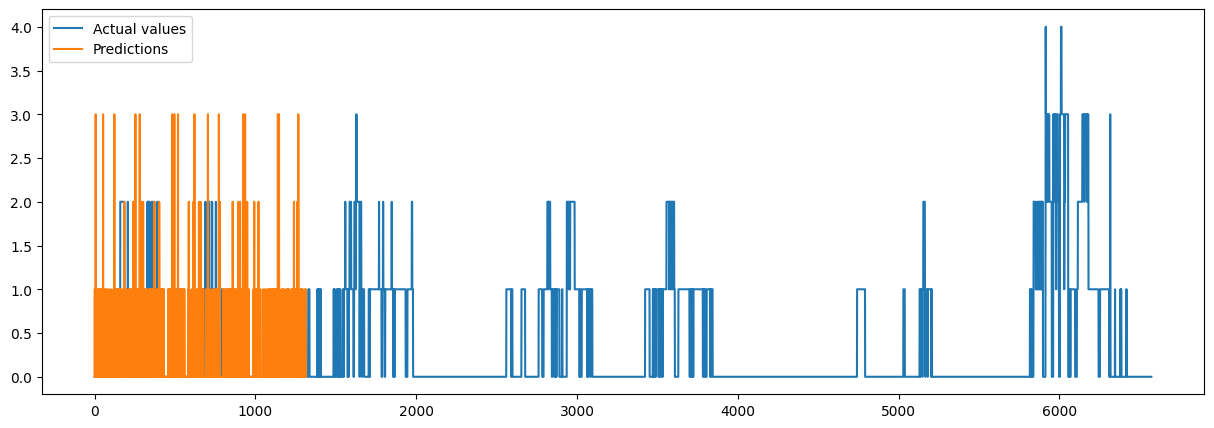

In [9]:
# plot the predictions and the actual values
# use plotly
import plotly.graph_objects as go

# create the figure
fig = go.Figure()

# add the actual values
fig.add_trace(go.Scatter(x=df['time'], y=df['peoplecount_rgb'], mode='lines', name='Actual values'))

# add the predictions
fig.add_trace(go.Scatter(x=df['time'], y=y_pred, mode='lines', name='Predictions'))

# show the figure
fig.show()

# also use matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(df['peoplecount_rgb'], label='Actual values')
plt.plot(y_pred, label='Predictions')

plt.legend()
plt.show()





We can see that the model gives pretty good results, but it is not perfect. We can try to improve it by using other models.

We will now try `Linear Regression`, `Random Forest`, and `Gradient Boosting` models.

The accuracy of the model is:  0.3825114365510819


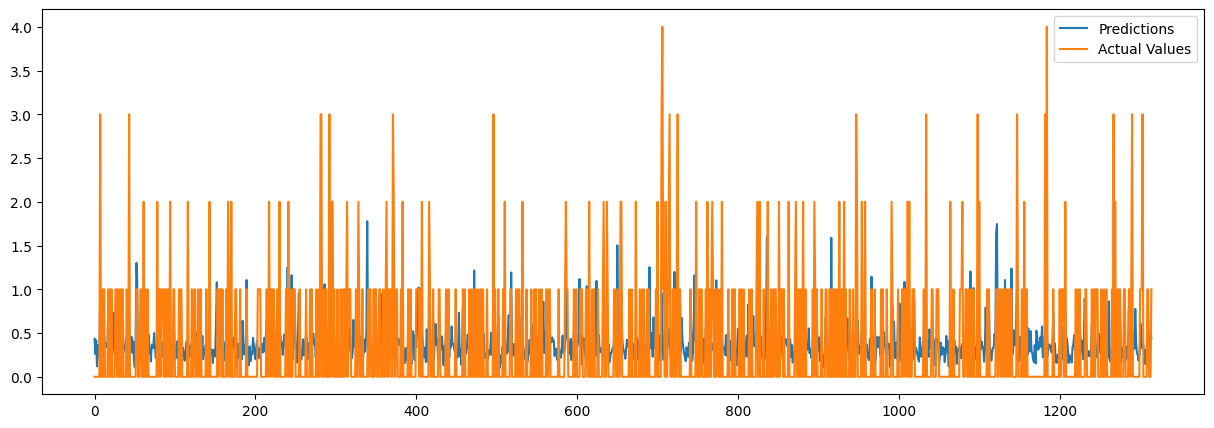

In [10]:
# try linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# split the data into train and test df['co2'], df['peoplecount_rgb']
X_train, X_test, y_train, y_test = train_test_split(df['co2'], df['peoplecount_rgb'], test_size=0.2, random_state=42)

# reshape the data
X_train = np.array(X_train).reshape(-1, 1)

# create the model
model = LinearRegression()

# fit the model
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test.values.reshape(-1, 1))

# calculate the accuracy
print('The accuracy of the model is: ', mean_squared_error(y_test, y_pred))

# plot the predictions and the actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(y_pred, label='Predictions')
plt.plot(y_test.values, label='Actual Values')
plt.legend()


The accuracy of the model is:  0.37408480857507187


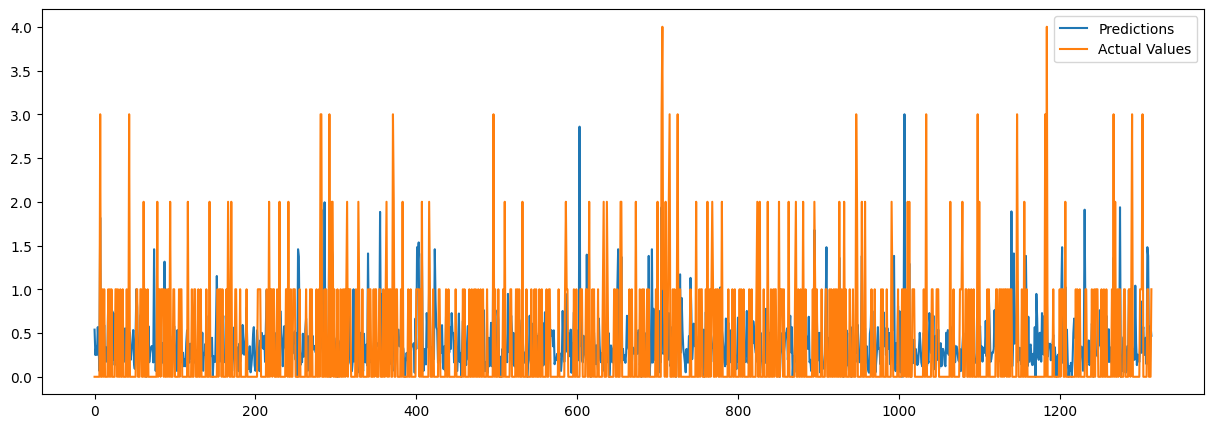

In [11]:
# try random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# split the data into train and test df['co2'], df['peoplecount_rgb']
X_train, X_test, y_train, y_test = train_test_split(df['co2'], df['peoplecount_rgb'], test_size=0.2, random_state=42)

# reshape the data
X_train = np.array(X_train).reshape(-1, 1)

# create the model
model = RandomForestRegressor()

# fit the model
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test.values.reshape(-1, 1))

# calculate the accuracy
print('The accuracy of the model is: ', mean_squared_error(y_test, y_pred))

# plot the predictions and the actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(y_pred, label='Predictions')
plt.plot(y_test.values, label='Actual Values')
plt.legend()

The accuracy of the model is:  0.366221409836378


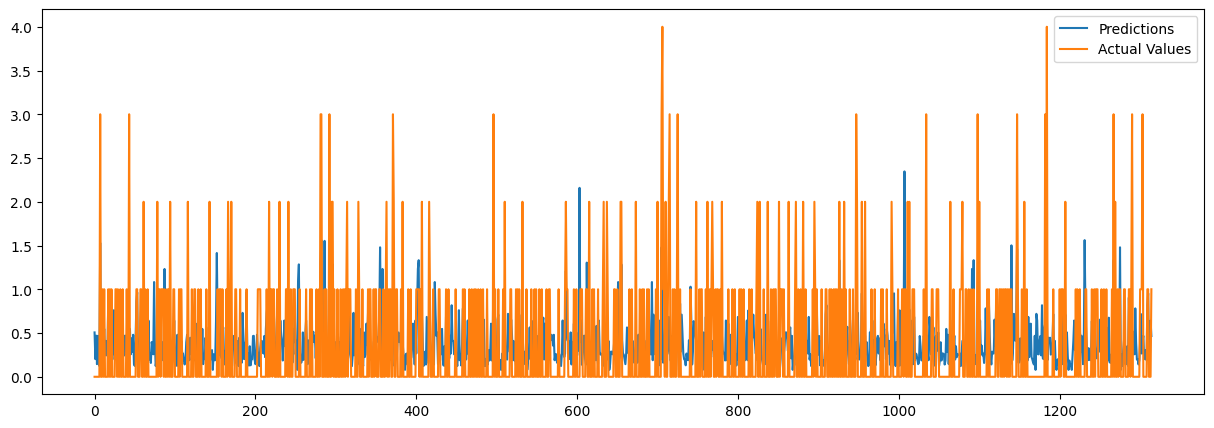

In [12]:
# uséanother classifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# split the data into train and test df['co2'], df['peoplecount_rgb']
X_train, X_test, y_train, y_test = train_test_split(df['co2'], df['peoplecount_rgb'], test_size=0.2, random_state=42)

# reshape the data
X_train = np.array(X_train).reshape(-1, 1)

# create the model
model = GradientBoostingRegressor()

# fit the model
model.fit(X_train, y_train)

# make predictions
y_pred = model.predict(X_test.values.reshape(-1, 1))

# calculate the accuracy
print('The accuracy of the model is: ', mean_squared_error(y_test, y_pred))

# plot the predictions and the actual values
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(y_pred, label='Predictions')
plt.plot(y_test.values, label='Actual Values')
plt.legend()

In [16]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Assuming X_train, y_train, X_test, and y_test are already defined


# Create a logistic regression model
logistic_regression = LogisticRegression()

# Fit the model
logistic_regression.fit(X_train, y_train)

X_test_reshaped = np.array(X_test).reshape(-1, 1)

# Predict using the reshaped data
y_pred = logistic_regression.predict(X_test_reshaped)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


Accuracy: 0.7201520912547529


c:\Users\elmah\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



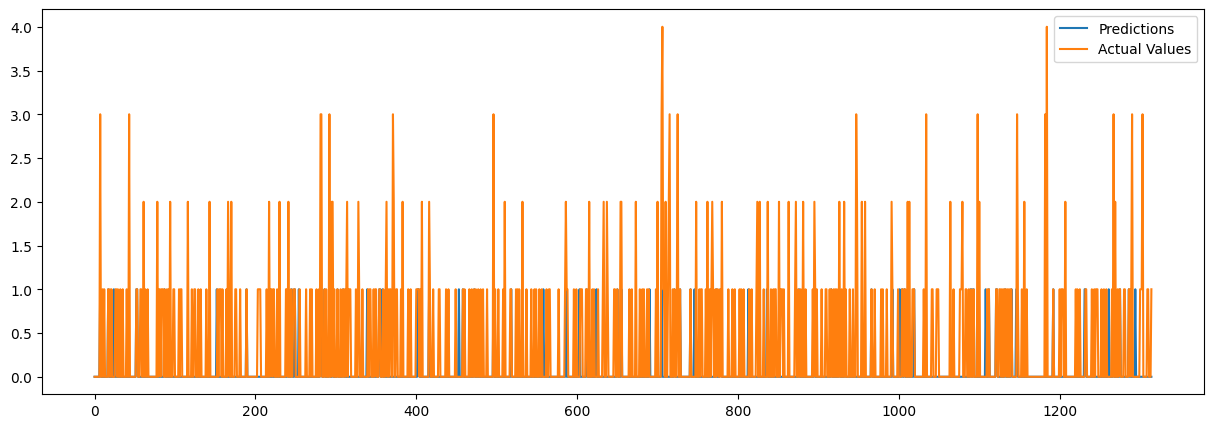

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(y_pred, label='Predictions')
plt.plot(y_test.values, label='Actual Values')
plt.legend()

As we can see, the problem is clearly not linear, so those models are not suitable for our problem.  

We will stick with the KNN model for now.

#### Occupancy Approach

We will now try not to predict the people count, but to predict the occupancy of the room.  

For that, we will also use time as input, in addition to the trend component of the CO2 data.  
We will create an `Occupancy` column in the data, which will be 1 if the people count is greater than 0, and 0 otherwise.  

And to use the time, we will only use the hour of the day for now, the day of the week and the month of the year could be added later to see if it improves the model.

In [18]:
# create new dataset of occupancy and co2, where the occupancy is 0 if the people count is 0 and 1 if the people count is greater than 0
df['occupancy'] = df['peoplecount_rgb'].apply(lambda x: 0 if x == 0 else 1)

# create the new dataset
new_df = df[['time', 'co2', 'occupancy', 'peoplecount_rgb']]

new_df['co2'] = trend_co2

# transform the time column only to hours
new_df['time_hours'] = new_df['time'].apply(lambda x: x.split(' ')[1].split(':')[0])

# convert the time column to int
new_df['time_hours'] = new_df['time_hours'].astype(int)

new_df.time_hours.unique()

array([ 1,  2,  3,  4,  5,  6,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23,  0,  7,  8])

The accuracy of the model is:  0.8068441064638783


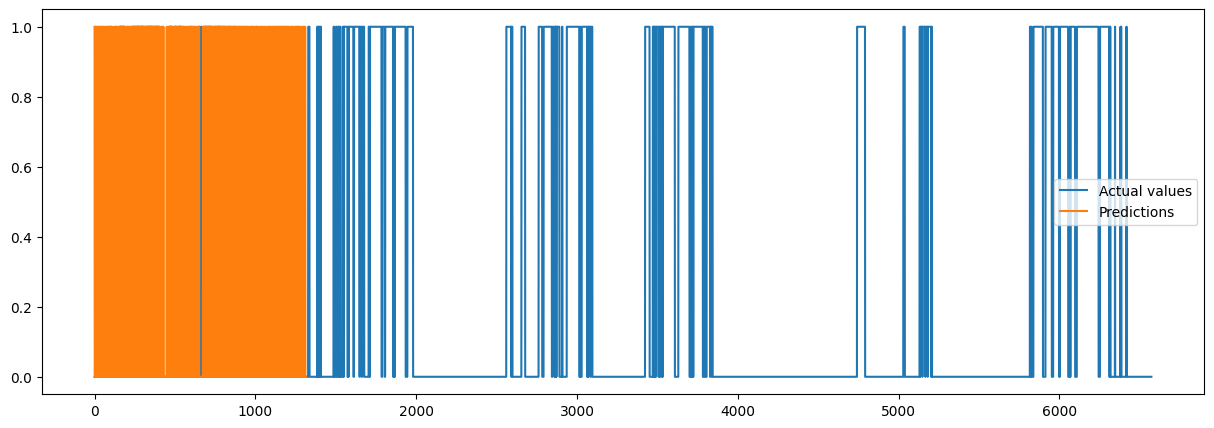

In [19]:
# test knn algorithm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# split the data into train and test df['time'] and df['co2'], df['peoplecount_rgb']
X_train, X_test, y_train, y_test = train_test_split(new_df[['time_hours', 'co2']], new_df['occupancy'], test_size=0.2, random_state=42)

# create the model
model_1 = KNeighborsClassifier(n_neighbors=3)

# fit the model
model_1.fit(X_train, y_train)

# make predictions
y_pred = model_1.predict(X_test)

# calculate the accuracy
print('The accuracy of the model is: ', accuracy_score(y_test, y_pred))

# plot the predictions and the actual values

fig = go.Figure()
fig.add_trace(go.Scatter(x=new_df['time'], y=new_df['occupancy'], mode='lines', name='Actual values'))
fig.add_trace(go.Scatter(x=new_df['time'], y=y_pred, mode='lines', name='Predictions'))
fig.show()

# also use matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(new_df['occupancy'], label='Actual values')
plt.plot(y_pred, label='Predictions')

plt.legend()
plt.show()

In [20]:
# try logistic regression

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print('Accuracy: ', accuracy_score(y_test, y_pred))

Accuracy:  0.7391634980988593


In [22]:
# plot using plotly
import plotly.graph_objects as go
import plotly.express as px

fig = go.Figure()
fig.add_trace(go.Scatter(x=new_df['time'], y=new_df['occupancy'], mode='lines', name='Actual values'))
fig.add_trace(go.Scatter(x=new_df['time'], y=y_pred, mode='lines', name='Predictions'))
fig.show()

As we can see, the model gives 80% accuracy, which is better than the people count case.  

We could also try adding time and try to predict people count instead of occupancy, but I think that would be more difficult.

The accuracy of the model is:  0.7749049429657795


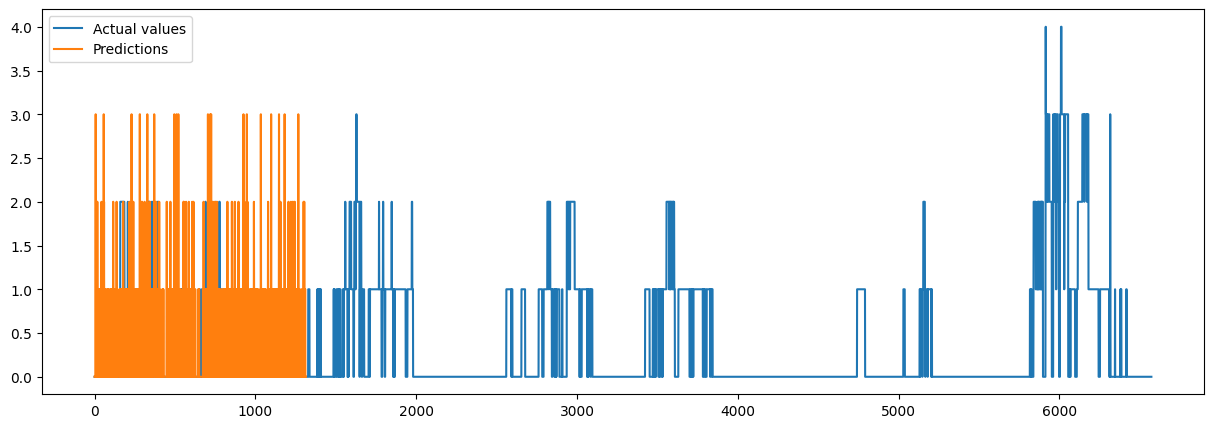

In [24]:
# split the data into train and test df['time'] and df['co2'], df['peoplecount_rgb']
X_train, X_test, y_train, y_test = train_test_split(new_df[['time_hours', 'co2']], new_df['peoplecount_rgb'], test_size=0.2, random_state=42)

# create the model
model_2 = KNeighborsClassifier(n_neighbors=3)

# fit the model
model_2.fit(X_train, y_train)

# make predictions
y_pred = model_2.predict(X_test)

# calculate the accuracy
print('The accuracy of the model is: ', accuracy_score(y_test, y_pred))

# plot the predictions and the actual values
fig = go.Figure()
fig.add_trace(go.Scatter(x=new_df['time'], y=new_df['peoplecount_rgb'], mode='lines', name='Actual values'))
fig.add_trace(go.Scatter(x=new_df['time'], y=y_pred, mode='lines', name='Predictions'))
fig.show()

# also use matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(new_df['peoplecount_rgb'], label='Actual values')
plt.plot(y_pred, label='Predictions')

plt.legend()
plt.show()

#### Adding Noise

I noticed that the noise data is pretty good, so why not add it to the training data. I will perform the same steps as above, but this time I will add the noise dataèè to the training data.

`You can check the testing notebook to see how the noise affected the training, and what the results were.`

### Let's now save the model to disk so we can load it later

In [25]:
import pickle
import os

def save_model(model, model_name):
    if not os.path.exists('model'):
        os.mkdir('model')
    pickle.dump(model, open('../model/'+model_name+'.pkl', 'wb'))
    
save_model(model_1, 'model')


### Conclusion

The method we used in that research is promising, but it needs to be improved. Also it requires a verified dataset with continuous people count data, which is not easy to find. The goal in the future is to be able to predict the people count in a room by only using the CO2 data, which would be very useful for the building management system.